# Time Series Mining: MLP, ARIMA, and Time Series Decomposition
## Introduction
Welcome to the "Time Series Mining: MLP, ARIMA, and Time Series Decomposition" Jupyter Notebook! This notebook explores various techniques for analyzing time series data, with a focus on Multilayer Perceptron (MLP) neural networks, AutoRegressive Integrated Moving Average (ARIMA) models, and time series decomposition.

## Background
Time series data represents a sequence of observations recorded over a period of time. Analyzing such data is essential for understanding trends, patterns, and making predictions. In this notebook, we delve into three powerful methods for time series analysis:

## Multilayer Perceptron (MLP):

MLPs are artificial neural networks capable of learning complex patterns in data.
We explore how MLPs can be applied to time series forecasting and uncover hidden temporal patterns.

AutoRegressive Integrated Moving Average (ARIMA):
ARIMA models are widely used for time series forecasting, capturing both trend and seasonality in the data.
This notebook demonstrates the implementation of ARIMA models and their effectiveness in predicting future values.
Time Series Decomposition:

Time Series Decomposition involves breaking down a time series into its constituent components, such as trend, seasonality, and residual.
We employ decomposition techniques to better understand the underlying structure of our time series data.


In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib.dates import DateFormatter
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# LOAD AND PREPARE DATA

For all three demonstrations of time-series analysis, we'll use the well-known `AirPassengers` dataset, which saved in the data folder as `AirPassengers.csv`. This datset is a monthly time series, which gives the monthly totals of international airline passengers (in thousands) from 1949 to 1960.

## Data Source

Box, G. E. P., Jenkins, G. M. and Reinsel, G. C. (1976) _Time Series Analysis, Forecasting and Control_. Third Edition. Holden-Day. Series G.


## Import Data

- Start by seeing the raw data.

In [2]:
pd.read_csv('/content/AirPassengers.csv')

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


## Prepare Data

- Import the data and parse the dates.

In [3]:
df = pd.read_csv('/content/AirPassengers.csv', parse_dates=['Month'], index_col=['Month'])

df.head()



,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


# Describe Data

- Get basic descriptive statistics.

In [4]:
df.describe()

,#Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


## Plot Data

- Display the complete dataset.

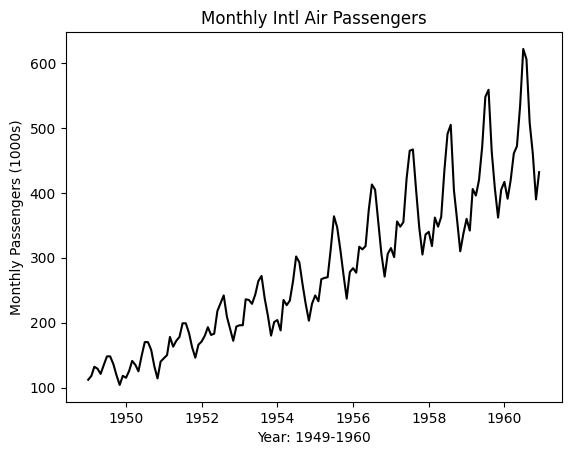

In [5]:
fig, ax = plt.subplots()
plt.xlabel('Year: 1949-1960')
plt.ylabel('Monthly Passengers (1000s)')
plt.title('Monthly Intl Air Passengers')
plt.plot(df, color='black')
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

# TIME SERIES DECOMPOSITION

- Decompose the time series into three components: trend, seasonal, and residuals or noise.
- This commands also plots the components.
- The argument `period` specifies that there are 12 observations (i.e., months) in the cycle.
- By default, `seasonal_decompose` performs an additive (as opposed to multiplicative) decomposition.

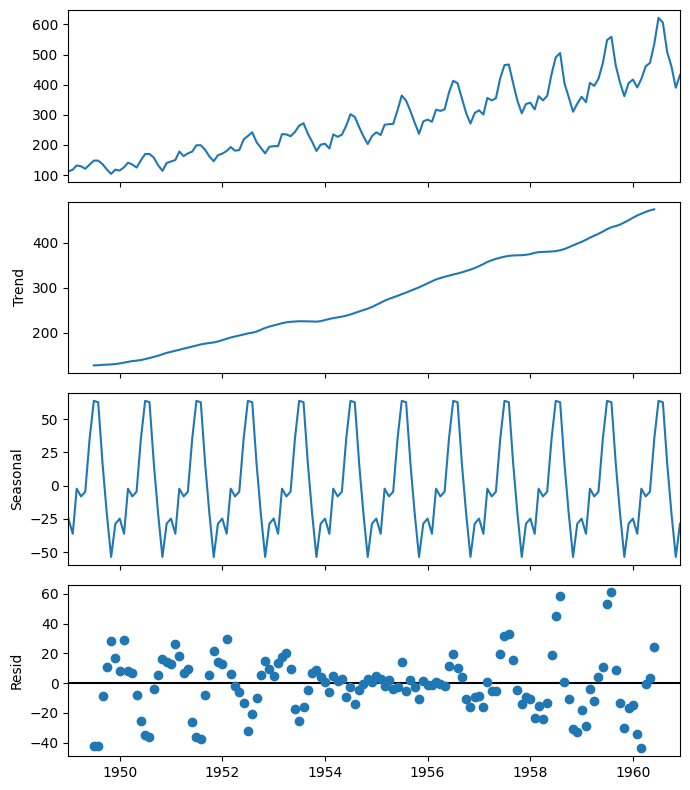

In [6]:
# Set the figure size
plt.rcParams['figure.figsize'] = [7, 8]

# Plot the decomposition components
sd = seasonal_decompose(df, period=12).plot()

- For growth over time, it may be more appropriate to use a multiplicative trend.
- The approach can show consistent changes by percentage.
- In this approach, the residuals should be centered on 1 instead of 0.

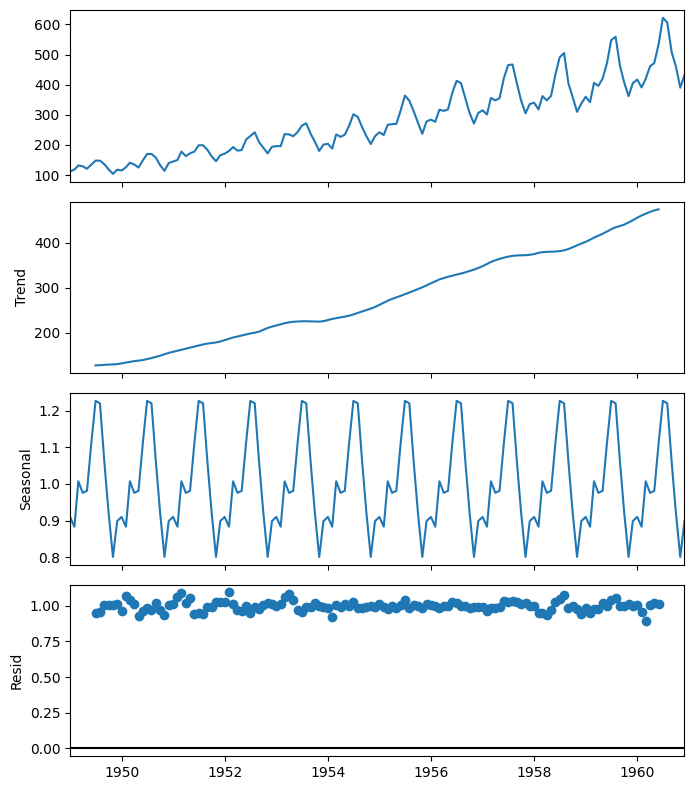

In [7]:
sd = seasonal_decompose(df, model='multiplicative').plot()

# MLP: MULTILAYER PERCEPTRON

In [8]:
df = pd.read_csv('/content/AirPassengers.csv', parse_dates=['Month'], index_col=['Month'])

# RESHAPE DATA
- Reshape the data into an `n x (k + 1)` matrix where `n` is the number of samples and `k` is the number of features.
- Use the last 12 lags of the time series as features (i.e. set `k` equal to 12) in order to capture a full seasonal cycle.

In [9]:
k=12
Z = []

for i in range(k + 1, df.shape[0] + 1):
    Z.append(df.iloc[(i - k - 1): i, 0])

Z = np.array(Z)

Z.shape



(132, 13)

In [16]:
# SPLIT DATA
split = np.int(0.8 * Z.shape[0])
Z_train, Z_test = Z[:split, :], Z[split:, :]

# The first 12 columns of `Z` are the features (lags).
# The last column of `Z` is the target.

In [17]:
# Normalize data using standard scaler

scaler = StandardScaler().fit(Z_train)
Z_train = scaler.transform(Z_train)
Z_test = scaler.transform(Z_test)

In [21]:
#Reformatting data
X_train, y_train = Z_train[:, :-1], Z_train[:, -1]
X_test, y_test = Z_test[:, :-1], Z_test[:, -1]

Plotting the Training & Testing Data

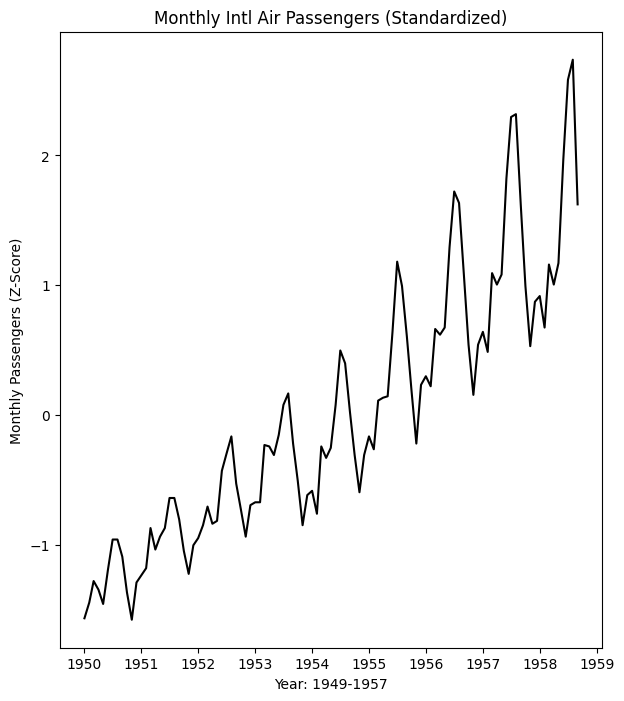

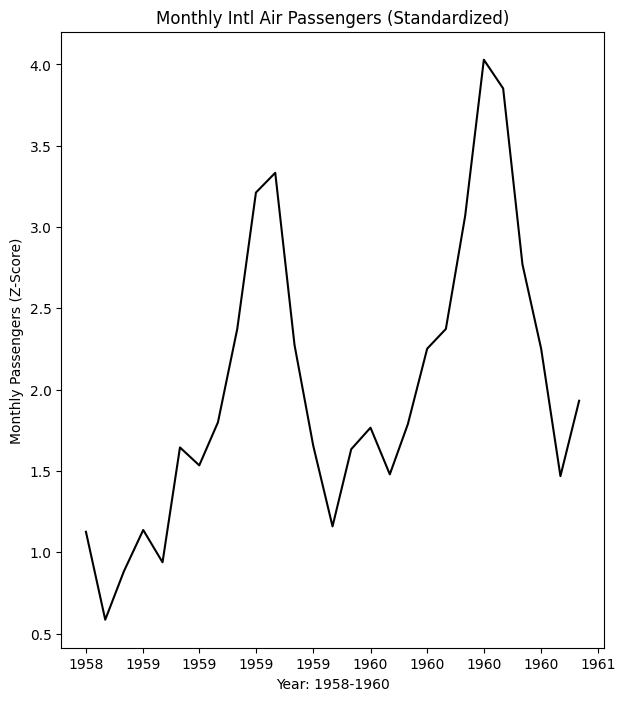

In [20]:
# Training data
fig, ax = plt.subplots()
plt.xlabel('Year: 1949-1957')
plt.ylabel('Monthly Passengers (Z-Score)')
plt.title('Monthly Intl Air Passengers (Standardized)')
plt.plot(pd.Series(y_train, index=df.index[k: (k + len(y_train))]), color='black')
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

# Testing data
fig, ax = plt.subplots()
plt.xlabel('Year: 1958-1960')
plt.ylabel('Monthly Passengers (Z-Score)')
plt.title('Monthly Intl Air Passengers (Standardized)')
plt.plot(pd.Series(y_test, index=df.index[-len(y_test):]), color='black')
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

# FIT MLP USING 20% VALIDATION SET

In [22]:
split_ = np.int(0.8 * X_train.shape[0])
X_train_, y_train_ = X_train[:split_, :], y_train[:split_]
X_valid_, y_valid_ =  X_train[split_:, :], y_train[split_:]

- Use the last 20% of the training data for validation.

In [23]:
def validation_loss(hidden_neurons):

    mlp = MLPRegressor(hidden_layer_sizes=(hidden_neurons,), max_iter=500, random_state=1, shuffle=False)

    mlp.fit(X_train_, y_train_)

    return mean_squared_error(y_valid_, mlp.predict(X_valid_))

- Calculate the validation loss corresponding to different numbers of hidden nodes.

In [24]:
params = [10, 25, 50, 75]
mse = [validation_loss(p) for p in params]

25


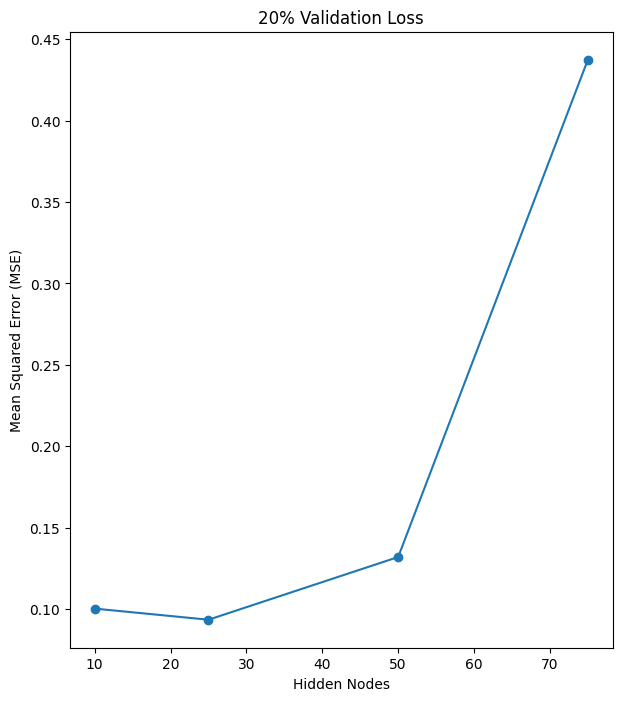

In [26]:
fig, ax = plt.subplots()
plt.xlabel('Hidden Nodes')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('20% Validation Loss')
plt.plot(params, mse, '-o')

print(params[np.argmin(mse)])

- Fit an MLP model with 25 hidden nodes to the training data.

In [32]:
mlp = MLPRegressor(hidden_layer_sizes=(25,), max_iter=500, random_state=1, shuffle=False)
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)

- Transform the data back to the original scale.

In [33]:
y_test_ = scaler.inverse_transform(np.hstack([X_test, y_test.reshape(-1, 1)]))[:, -1]
y_pred_ = scaler.inverse_transform(np.hstack([X_test, y_pred.reshape(-1, 1)]))[:, -1]

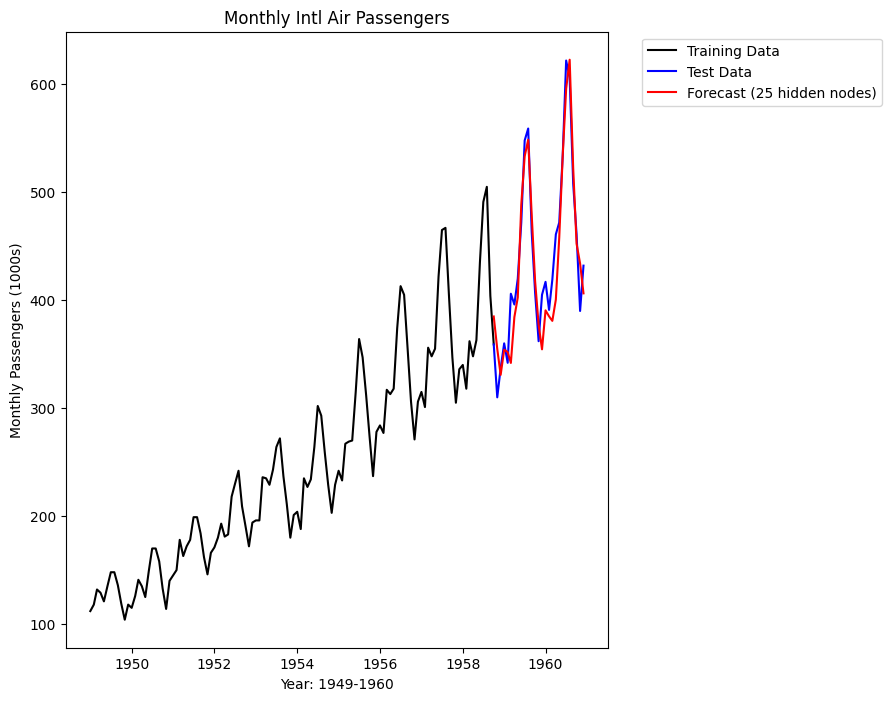

In [34]:
fig, ax = plt.subplots()
plt.xlabel('Year: 1949-1960')
plt.ylabel('Monthly Passengers (1000s)')
plt.title('Monthly Intl Air Passengers')
plt.plot(df.iloc[:(k + len(y_train) + 1), :], color='black', label='Training Data')
plt.plot(pd.Series(y_test_, index=df.index[-len(y_test):]), color='blue', label='Test Data')
plt.plot(pd.Series(y_pred_, index=df.index[-len(y_test):]), color='red', label='Forecast (25 hidden nodes)')
plt.legend(bbox_to_anchor=(1.05, 1))
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

- FIT MLP USING FIVE-FOLD CROSS-VALIDATION

In [35]:
tscv = TimeSeriesSplit(n_splits=5)

- Use the mean squared error (MSE) as cross-validation loss.

In [36]:
def cross_validation_loss(hidden_neurons):

    mse = []

    for train_split_, valid_split_ in tscv.split(X_train):

        X_train_, y_train_ = X_train[train_split_], y_train[train_split_]
        X_valid_, y_valid_ = X_train[valid_split_], y_train[valid_split_]

        mlp = MLPRegressor(hidden_layer_sizes=(hidden_neurons,), max_iter=500, random_state=1, shuffle=False)

        mlp.fit(X_train_, y_train_)

        mse.append(mean_squared_error(y_valid_, mlp.predict(X_valid_)))

    return np.mean(mse)

- Calculate the cross validation loss corresponding to different numbers of hidden nodes.

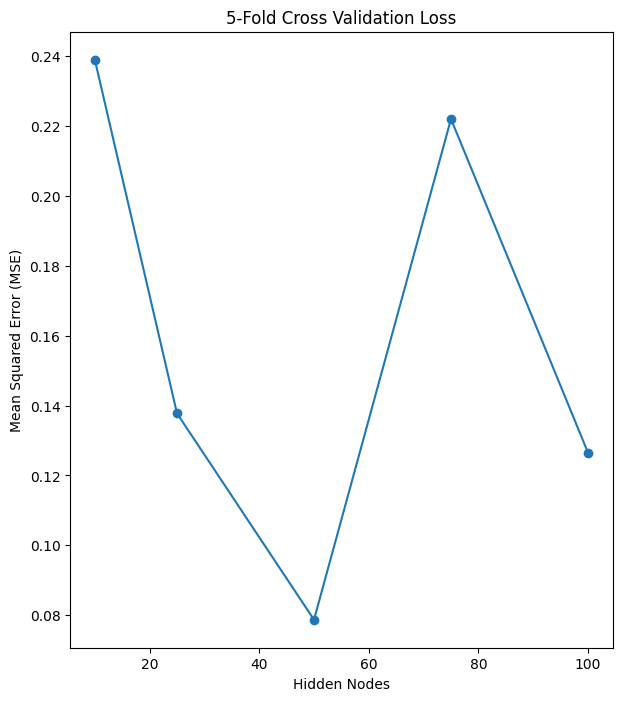

In [47]:
params = [10, 25, 50, 75, 100]
mse = [cross_validation_loss(p) for p in params]

fig, ax = plt.subplots()
plt.xlabel('Hidden Nodes')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('5-Fold Cross Validation Loss')
plt.plot(params, mse, '-o')

- Fit the model with 50 hidden layers that were calculated above:

In [41]:
mlp = MLPRegressor(hidden_layer_sizes=(50,), max_iter=500, random_state=1, shuffle=False)
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)

In [42]:
#Transform back the data
y_test_ = scaler.inverse_transform(np.hstack([X_test, y_test.reshape(-1, 1)]))[:, -1]
y_pred_ = scaler.inverse_transform(np.hstack([X_test, y_pred.reshape(-1, 1)]))[:, -1]

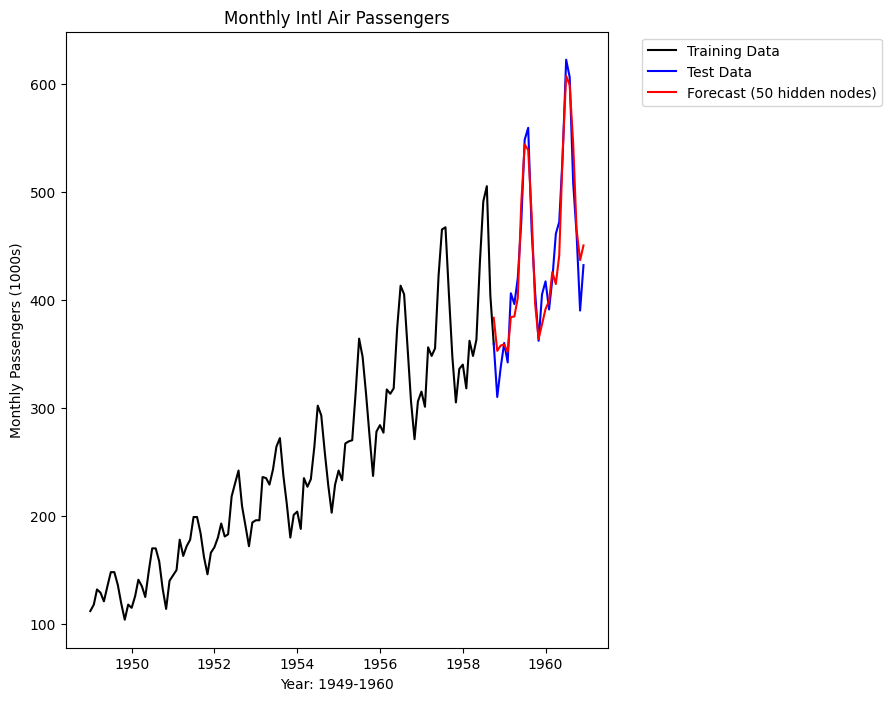

In [43]:
# Data Plot
fig, ax = plt.subplots()
plt.xlabel('Year: 1949-1960')
plt.ylabel('Monthly Passengers (1000s)')
plt.title('Monthly Intl Air Passengers')
plt.plot(df.iloc[:(k + len(y_train) + 1), :], color='black', label='Training Data')
plt.plot(pd.Series(y_test_, index=df.index[-len(y_test):]), color='blue', label='Test Data')
plt.plot(pd.Series(y_pred_, index=df.index[-len(y_test):]), color='red', label='Forecast (50 hidden nodes)')
plt.legend(bbox_to_anchor=(1.05, 1))
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

# ARIMA: Autoregressive Integrated Moving Average

In [3]:
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from pmdarima.arima import auto_arima

In [4]:
df = pd.read_csv('/content/AirPassengers.csv', parse_dates=['Month'], index_col=['Month'])

## Create Training & Testing Dataset

- Select data from before 1958.

In [6]:
trn = df.loc[df.index < '1958-01-01']

tst = df.loc[df.index >= '1958-01-01']

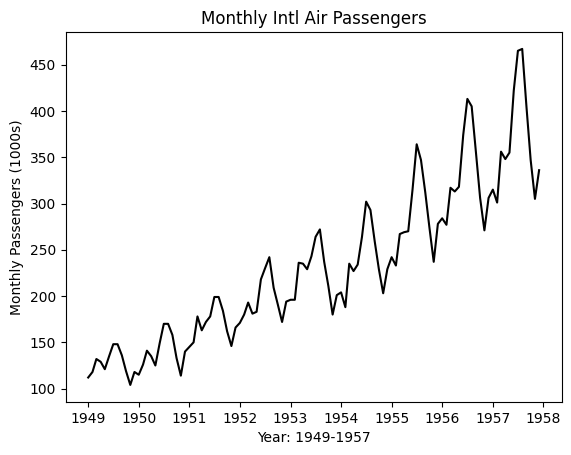

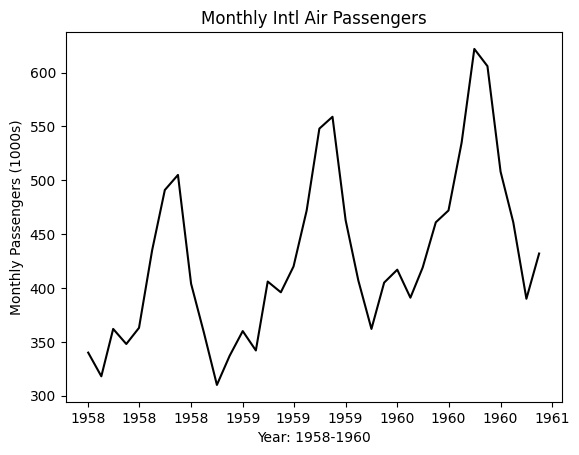

In [7]:
fig, ax = plt.subplots()
plt.xlabel('Year: 1949-1957')
plt.ylabel('Monthly Passengers (1000s)')
plt.title('Monthly Intl Air Passengers')
plt.plot(trn, color='black')
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

fig, ax = plt.subplots()
plt.xlabel('Year: 1958-1960')
plt.ylabel('Monthly Passengers (1000s)')
plt.title('Monthly Intl Air Passengers')
plt.plot(tst, color='black')
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

# PREPARE MODEL

## Test Stationarity

ARIMA requires non-stationary data. That is, ARIMA needs data where the mean, the variance, and/or the covariance vary over time. Non-stationary data shows significant correlations when lagged. A "correlogram" graph (or ACF plot) shows the degree of correlation at different values of lag. Ideally, none of the lag values will fall in the range of nonsignificant correlations.

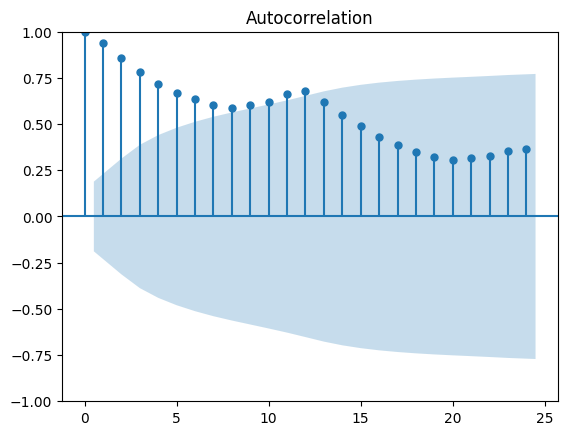

In [8]:
trn_acf = plot_acf(trn, lags=24)

## Linear Model
- Fit a linear regression model to serve as a baseline.
- The dependent (or endogenous) variable is the number of passengers.
- The independent (or exogenous) variable is a linear time trend, including a constant (or intercept).

In [9]:
lr = sm.OLS(endog=trn['#Passengers'], exog=sm.add_constant(np.arange(1, 1 + trn.shape[0]))).fit()
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:            #Passengers   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     526.7
Date:                Mon, 13 Nov 2023   Prob (F-statistic):           6.40e-43
Time:                        17:07:37   Log-Likelihood:                -536.80
No. Observations:                 108   AIC:                             1078.
Df Residuals:                     106   BIC:                             1083.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         95.0422      6.820     13.936      0.0

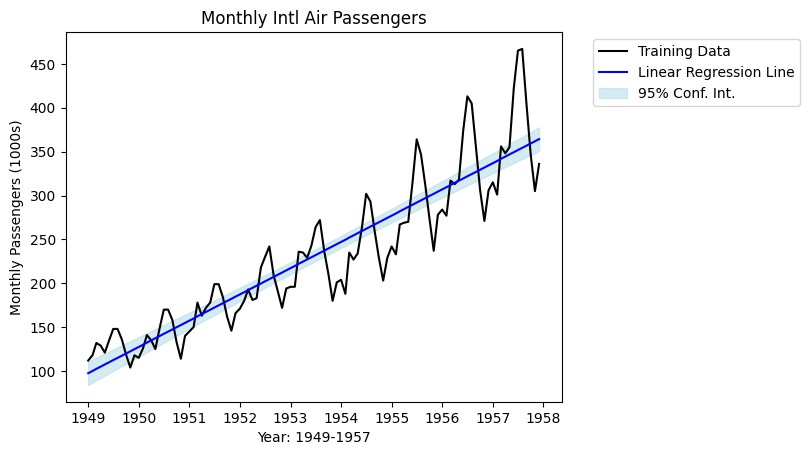

In [10]:
#Extract the fitted values.

y_hat = lr.fittedvalues

#Extract the 95% prediction interval.
y_ci = lr.get_prediction().conf_int(alpha=0.05)

#Graph time series with linear regression line and corresponding 95% prediction interval.
fig, ax = plt.subplots()
plt.xlabel('Year: 1949-1957')
plt.ylabel('Monthly Passengers (1000s)')
plt.title('Monthly Intl Air Passengers')
plt.plot(trn, color='black', label='Training Data')
plt.plot(y_hat, color='blue', label='Linear Regression Line')
plt.fill_between(y_hat.index, y_ci[:, 0], y_ci[:, 1], color='lightblue', alpha=0.5, label='95% Conf. Int.')
plt.legend(bbox_to_anchor=(1.05, 1))
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

- TRAIN MODEL: Train Model

Find the best ARIMA order using the `auto_arima` function in the `pmdarima` package. Note that the `auto_arima` function assumes that the time series is non-seasonal by default (i.e. the seasonal period "m" is set equal to 1 by default). In what follows we set "m" equal to 12 to ensure that the selected optimal model takes into account the annual seasonality observed in the time series (one cycle every 12 months).    

Note: We are actually conducting a variation on ARIMA called "SARIMAX," or "Seasonal Auto-Regressive Integrated Moving Average with Exogenous Factors."

In [11]:
auto_arima_model = auto_arima(trn, m=12, with_intercept=False, suppress_warnings=True)
print(auto_arima_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  108
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -350.001
Date:                            Mon, 13 Nov 2023   AIC                            704.001
Time:                                    17:16:14   BIC                            709.109
Sample:                                01-01-1949   HQIC                           706.065
                                     - 12-01-1957                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2411      0.091     -2.648      0.008      -0.420      -0.063
sigma2        92.7499     13.439   

First set of numbers is for the basic, non-seasonal model    
&nbsp;  1 &nbsp;&nbsp;&nbsp;    # p: Auto-regressive (AR) order   
&nbsp;  1 &nbsp;&nbsp;&nbsp;    # d: Integrate (I), or degree of differencing   
&nbsp;  0 &nbsp;&nbsp;&nbsp;    # q: Moving average (MA) order   

In [12]:
auto_arima_model.order

(1, 1, 0)

Second set of numbers is for seasonality    
&nbsp;  0 &nbsp;&nbsp;&nbsp;    # P: Auto-regressive (AR) order    
&nbsp;  1 &nbsp;&nbsp;&nbsp;    # D: Integrate (I), or degree of differencing    
&nbsp;  0 &nbsp;&nbsp;&nbsp;    # Q: Moving average (MA) order   
&nbsp;  12 &nbsp;  # M: Model period or seasonality   

In [13]:
auto_arima_model.seasonal_order


(0, 1, 0, 12)

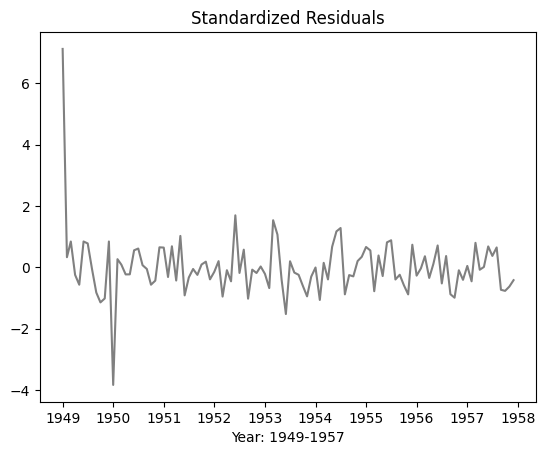

In [14]:
#Extract the residuals.
resid = auto_arima_model.resid()
#Plot the standardized residuals.
fig, ax = plt.subplots()
plt.plot(trn.index, stats.zscore(resid), color='gray')
plt.title('Standardized Residuals')
plt.xlabel('Year: 1949-1957')
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

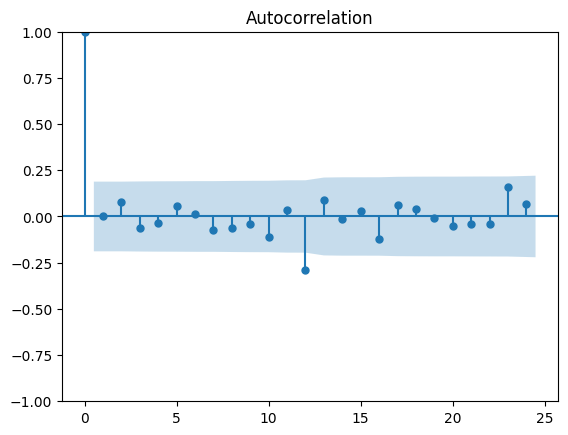

In [19]:
res_acf = plot_acf(resid, lags=24)

 TEST MODEL
- Fit the best model to the training data.

In [25]:
auto_arima_model.fit(trn)

ARIMA(order=(1, 1, 0), scoring_args={}, seasonal_order=(0, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [31]:
#Extract the time series of model predictions.
arima_predictions = auto_arima_model.predict(n_periods=36, alpha=0.05, return_conf_int=True)
y_pred = pd.Series(arima_predictions[0], index=tst.index)

#Extract the 95% prediction interval.
y_pred_lb, y_pred_ub = arima_predictions[1][:, 0], arima_predictions[1][:, 1]

- Graph the training data (1949-1957).
- Add the predictions for the testing data (1958-1960).
- Add observed values from testing data.

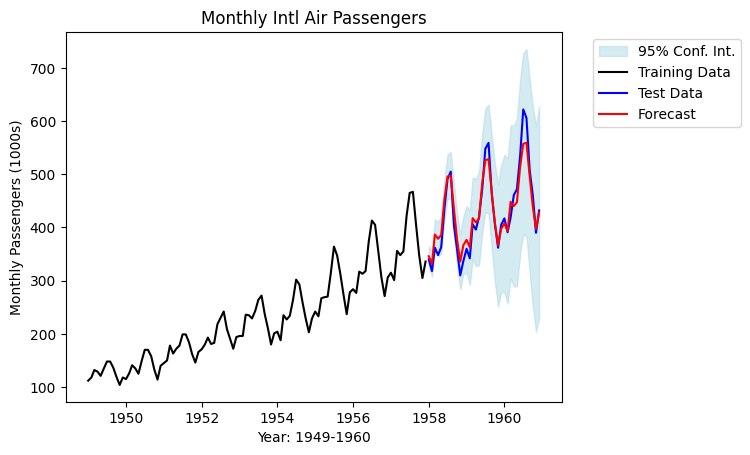

In [29]:
fig, ax = plt.subplots()
plt.xlabel('Year: 1949-1960')
plt.ylabel('Monthly Passengers (1000s)')
plt.title('Monthly Intl Air Passengers')
plt.fill_between(tst.index, y_pred_lb, y_pred_ub, color='lightblue', alpha=0.5, label='95% Conf. Int.')
plt.plot(trn, color='black', label='Training Data')
plt.plot(tst, color='blue', label='Test Data')
plt.plot(y_pred, color='red', label='Forecast')
plt.legend(bbox_to_anchor=(1.05, 1))
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

- Create a dataframe with the observed values for the testing dataset.
- Add the predictions from the ARIMA model.
- Add the low and high boundaries for the 95% confidence intervals.

In [30]:
tst_pred = pd.DataFrame({
    'Actual': tst.iloc[:, 0].values,
    'Point Forecast': y_pred.values,
    'Lo 95': y_pred_lb,
    'Hi 95': y_pred_ub
    }, index=tst.index)

tst_pred.head()

,Actual,Point Forecast,Lo 95,Hi 95
Month,,,,
1958-01-01,340,345.964471,327.088699,364.840243
1958-02-01,318,331.731920,308.036230,355.427610
1958-03-01,362,386.787992,358.515740,415.060244
1958-04-01,348,378.774472,346.695454,410.853490
1958-05-01,363,385.777732,350.270764,421.284700
